In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

#Trainer Imports
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


from matplotlib import pyplot as plt #for visualizing 

#From the local python files
from datasets import DenoisingPairedDataset
#from trainer import DenoisingTrainer #What is going awn
#from trainer import perceptual_loss, combined_loss, DenoisingTrainer
import torch.nn.functional as F



# Root directories

In [232]:
root_dir = 'datasets/aquarium-data-cots/aquarium_pretrain'

splits = ['train', 'test','valid']

model_path = '/home/ubuntu/cs230_VIVEKA/saved_models'

# Denoising Model Class

### Architecture 1: basic model.
consider adding: dropout, batch normalization layers, skip connections

In [233]:
class DenoisingCNN(nn.Module):
    ''' Simple CNN architecture for the first iteration of Denoising model training.
        simple encoder-decoder structure with dropout of
        0.2 initially and 0.4 at the last layer of encoder (and no dropout for the final layer of the decoder).
    '''
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)#,
            #nn.Dropout(0.4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),

            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Architecture 1.5 (WIP)

In [234]:
class DenoisingCNN_v2(nn.Module):
    ''' Simple CNN architecture for the first iteration of Denoising model training.
        simple encoder-decoder structure with dropout of
        0.2 initially and 0.4 at the last layer of encoder (and no dropout for the final layer of the decoder).
    '''
    def __init__(self):
        super(DenoisingCNN_v2, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.4)
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),

        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Architecture 2
find pre existing model that targets issues of the images, 

In [235]:
class DenoisingUNet(nn.Module):
    ''' Denoising CNN class with a U-Net architecture.
        3 contractive layers (encoder) and 3 expansive layers (decode).
        Final layer is Sigmoid to map pixel values to (0,1).
    '''
    def __init__(self):
        super(DenoisingUNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc_conv1a = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Additional layer
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2a = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Additional layer
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc_conv3a = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Additional layer
        self.dropout3 = nn.Dropout(0.4)
        
        # Decoder
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.dropout4 = nn.Dropout(0.2)

        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.dropout5 = nn.Dropout(0.2)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        x1 = self.enc_conv1a(x1)  # Pass through additional layer
        x1_pooled = self.pool1(x1)
        x1_pooled = self.dropout1(x1_pooled)

        x2 = self.enc_conv2(x1_pooled)
        x2 = self.enc_conv2a(x2)  # Pass through additional layer
        x2_pooled = self.pool2(x2)
        x2_pooled = self.dropout2(x2_pooled)

        x3 = self.enc_conv3(x2_pooled)
        x3 = self.enc_conv3a(x3)  # Pass through additional layer
        x3 = self.dropout3(x3)

        # Decoder with Skip Connections
        x4 = self.dec_conv1(x3)
        x4 = self.dropout4(x4)
        x4 = torch.cat((x4, x2), dim=1)  # Skip connection from encoder layer 2

        x5 = self.dec_conv2(x4)
        x5 = self.dropout5(x5)
        x5 = torch.cat((x5, x1), dim=1)  # Skip connection from encoder layer 1

        out = self.final_conv(x5)

        return out

### Architecture 3.1

In [236]:
class ImprovedDenoisingUNet(nn.Module):
    def __init__(self):
        super(ImprovedDenoisingUNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=2, stride=2),  # Skip connection
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(32 + 32, 3, kernel_size=3, padding=1)  # Skip connection

    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        x1_pooled = self.pool1(x1)

        x2 = self.enc_conv2(x1_pooled)
        x2_pooled = self.pool2(x2)

        x3 = self.enc_conv3(x2_pooled)

        # Decoder with Skip Connections
        x4 = self.dec_conv1(x3)
        x4 = torch.cat((x4, x2), dim=1)  # Skip connection

        x5 = self.dec_conv2(x4)
        x5 = torch.cat((x5, x1), dim=1)  # Skip connection

        out = self.final_conv(x5)

        return torch.sigmoid(out)  # Map to [0, 1]


### Architecture 3.2

In [237]:
class ResidualUNet(nn.Module):
    def __init__(self):
        super(ResidualUNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        x1_pooled = self.pool(x1)

        x2 = self.enc_conv2(x1_pooled)
        x2_pooled = self.pool(x2)

        # Bottleneck
        bottleneck = self.bottleneck(x2_pooled)

        # Decoder
        x3 = self.dec_conv1(bottleneck) + x2  # Residual connection
        x4 = self.dec_conv2(x3) + x1  # Residual connection

        out = torch.sigmoid(self.final_conv(x4))
        return out

# Denoising Trainer

In [260]:
#DenoisingTrainer:
import torch.nn as nn
from skimage.metrics import peak_signal_noise_ratio as psnr #DenoisingTrainer
from skimage.metrics import structural_similarity as ssim #DenoisingTrainer
from torchvision.models import vgg16
#from pytorch_msssim import ssim
import torch.optim as optim

def perceptual_loss(output, target):
    ''' Perceptual loss calculation function for Denoising model.
    '''
    vgg = vgg16(pretrained=True).features[:16].to(output.device)
    vgg.eval()
    with torch.no_grad():
        output_features = vgg(output)
        target_features = vgg(target)
    return torch.mean((output_features - target_features) ** 2)


def combined_loss(output, target):
    ''' Combined loss function with MSE, perceptual loss, and SSIM loss for Denoising model.
    '''
    perceptual = perceptual_loss(output, target)
    
    mse_loss = nn.MSELoss()(output, target)
    
    #ssim_loss = 1 - ssim(output, target, data_range=1.0, size_average=True)

    return mse_loss + 0.5 * perceptual # + 0.1 * ssim_loss

In [261]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

class DenoisingTrainer:
    def __init__(self, model, device, criterion, optimizer, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.save_path = save_path

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def train(self, train_loader, valid_loader, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_train_loss = 0.0
            total_train_samples = 0

            for noisy_images, clean_images in train_loader:
                noisy_images = noisy_images.to(self.device)
                clean_images = clean_images.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(noisy_images)
                loss = self.criterion(outputs, clean_images) #loss definition here -- depends on definition in training pipeline
                loss.backward()
                self.optimizer.step()

                running_train_loss += loss.item() * noisy_images.size(0)
                total_train_samples += noisy_images.size(0)

            epoch_train_loss = running_train_loss / total_train_samples
            self.train_losses.append(epoch_train_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}')

            self.model.eval()
            running_val_loss = 0.0
            total_val_samples = 0

            with torch.no_grad():
                for noisy_images, clean_images in valid_loader:
                    noisy_images = noisy_images.to(self.device)
                    clean_images = clean_images.to(self.device)

                    outputs = self.model(noisy_images)
                    loss = self.criterion(outputs, clean_images) #Criterion referenced here

                    running_val_loss += loss.item() * noisy_images.size(0)
                    total_val_samples += noisy_images.size(0)

            epoch_val_loss = running_val_loss / total_val_samples
            self.val_losses.append(epoch_val_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}')

            if epoch_val_loss < self.best_val_loss:
                self.best_val_loss = epoch_val_loss
                torch.save(self.model.state_dict(), self.save_path)
                print(f"Model saved with validation loss: {epoch_val_loss:.4f}")

        #Plotting train and validation loss per epoch at the end of train() function
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, data_loader):
        ''' Evaluates MSE loss, pSNR, and SSIM of the model output to the ground truth labels
            using skimage.metrics for the latter two metrics.
        '''
        self.model.eval()
        running_loss = 0.0
        total_samples = 0
        total_psnr = 0.0
        total_ssim = 0.0

        with torch.no_grad():
            for noisy_images, clean_images in data_loader:
                noisy_images = noisy_images.to(self.device)
                clean_images = clean_images.to(self.device)

                outputs = self.model(noisy_images)
                loss = self.criterion(outputs, clean_images) #Criterion

                running_loss += loss.item() * noisy_images.size(0)
                total_samples += noisy_images.size(0)

                # METRICS pSNR, SSIM ADDED HERE
                outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
                clean_images_np = clean_images.cpu().numpy().transpose(0, 2, 3, 1)
                
                # debugging ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                # print("Output shape:", outputs_np.shape)
                # print("Clean image shape:", clean_images_np.shape)
                # end debugging ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

                for o, c in zip(outputs_np, clean_images_np):
                    total_psnr += psnr(c, o, data_range=1.0)
                    total_ssim += ssim(c, o, data_range=1.0, win_size=3, channel_axis=-1)

        avg_loss = running_loss / total_samples
        avg_psnr = total_psnr / total_samples
        avg_ssim = total_ssim / total_samples

        print(f"Avg Loss: {avg_loss:.4f}, Avg PSNR: {avg_psnr:.4f}, Avg SSIM: {avg_ssim:.4f}")
        return avg_loss, avg_psnr, avg_ssim


# Main model training pipeline

##### create datasets, dataloaders, model, trainer

In [240]:
hyperparams = ['batch_size', 'lr', 'num_epochs', 'dropout_rate']

In [241]:
#Transforms
normalization_mean = normalization_std = [0.5, 0.5, 0.5]

transform_normalize = T.Compose([T.Resize((224, 224)),  #resize
                        T.ToTensor(),                   # to tensor
                        T.Normalize(mean=normalization_mean, std=normalization_std)]) #normalize

transform_regular = T.ToTensor()

transform_resize = T.Compose( [ T.Resize((224,224)) , T.ToTensor() ] ) #IMPORTANT: size is taken from datasets.py transform in order to match 

create dataset

In [242]:
# train_data = DenoisingPairedDataset(root_dir=root_dir, split='train', transform=transform_resize)
# valid_data = DenoisingPairedDataset(root_dir=root_dir, split='valid', transform=transform_resize)
# test_data = DenoisingPairedDataset(root_dir=root_dir, split='test', transform=transform_resize)

In [243]:
train_data = DenoisingPairedDataset(root_dir=root_dir, split='train', transform=transform_resize) #Running this cell with noisy_images2 as input dir
valid_data = DenoisingPairedDataset(root_dir=root_dir, split='valid', transform=transform_resize)
test_data = DenoisingPairedDataset(root_dir=root_dir, split='test', transform=transform_resize)

In [244]:
len(train_data[0][1]) #index 2 is file name if datasets has not be updated

3

In [245]:
train_data[0][1].shape

torch.Size([3, 224, 224])

In [246]:
# '''Check the range of data loader image pixel values'''
# for images, labels in train_data:
#     print(images.min(), images.max()) 

create DataLoaders

In [267]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

###### visualize dataset from dataloaders

In [248]:
test = next(iter(train_loader))
#test[0][0]

In [249]:
import torchvision.transforms as transforms

/home/ubuntu/cs230_VIVEKA/datasets/aquarium-data-cots/aquarium_pretrain/train/noisy_images2

In [250]:
test_path = os.path.join(root_dir, splits[0], 'noisy_images2')
test_path

'datasets/aquarium-data-cots/aquarium_pretrain/train/noisy_images2'

In [251]:
#tensor = torch.randn(3, 224, 224)

# Convert the tensor to a PIL Image
transform = transforms.ToPILImage()

    # Extract the i-th image from the batch
tensor_image_x = test[0][4]  # Extract the i-th image from the batch
tensor_image_y = test[1][4]
tensor_image_filepath = test[2][4]
# Convert the tensor to a PIL Image
image = transform(tensor_image_x)
image2 = transform(tensor_image_y)

# Display the image
image


IndexError: list index out of range

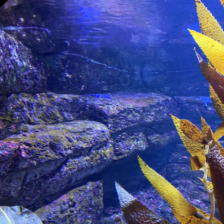

In [ ]:
image2

In [ ]:
tensor_image_filepath

'IMG_2548_jpeg_jpg.rf.b9a775702d3c300735ef690866a1c7cc.jpg'

###### end visualization

create Model, device

In [268]:
#define models
model_simple = DenoisingCNN()
model_unet = DenoisingUNet()

# model_simple_v2 = DenoisingCNN_v2()

In [269]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model_simple

model.to(device)

#MSE Loss
# criterion = nn.MSELoss()

#Combined loss
# criterion = combined_loss

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

Using device: cuda


In [270]:
# trainer = DenoisingTrainer(model, device, criterion, optimizer, save_path="saved_models/best_denoising_model_unet.pth")

trainer = DenoisingTrainer(model, device, criterion=combined_loss, optimizer=optimizer, save_path="saved_models/best_denoising_model_unet.pth")


##### Train model

Epoch 1/10, Training Loss: 1.2866
Epoch 1/10, Validation Loss: 1.2610
Model saved with validation loss: 1.2610
Epoch 2/10, Training Loss: 1.2590
Epoch 2/10, Validation Loss: 1.2082
Model saved with validation loss: 1.2082
Epoch 3/10, Training Loss: 1.2629
Epoch 3/10, Validation Loss: 1.2354
Epoch 4/10, Training Loss: 1.1988
Epoch 4/10, Validation Loss: 1.1581
Model saved with validation loss: 1.1581
Epoch 5/10, Training Loss: 1.1713
Epoch 5/10, Validation Loss: 1.1574
Model saved with validation loss: 1.1574
Epoch 6/10, Training Loss: 1.1607
Epoch 6/10, Validation Loss: 1.1380
Model saved with validation loss: 1.1380
Epoch 7/10, Training Loss: 1.1475
Epoch 7/10, Validation Loss: 1.1309
Model saved with validation loss: 1.1309
Epoch 8/10, Training Loss: 1.1401
Epoch 8/10, Validation Loss: 1.1227
Model saved with validation loss: 1.1227
Epoch 9/10, Training Loss: 1.1284
Epoch 9/10, Validation Loss: 1.1018
Model saved with validation loss: 1.1018
Epoch 10/10, Training Loss: 1.1166
Epoch 1

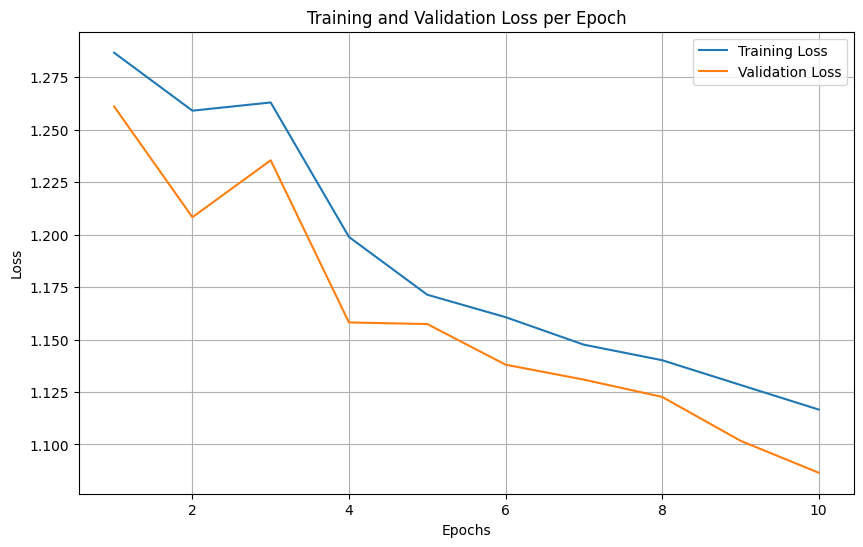

In [271]:
num_epochs = 10

trainer.train(train_loader, valid_loader, num_epochs=num_epochs)

##### Evaluate model

In [272]:
val_loss, val_psnr, val_ssim = trainer.evaluate(valid_loader)
#print(f"Validation - Loss: {val_loss:.4f}, PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")

test_loss, test_psnr, test_ssim = trainer.evaluate(test_loader)
#print(f"Test - Loss: {test_loss:.4f}, PSNR: {test_psnr:.4f}, SSIM: {test_ssim:.4f}")


Avg Loss: 1.0866, Avg PSNR: 17.7539, Avg SSIM: 0.5772
Avg Loss: 1.0755, Avg PSNR: 17.6596, Avg SSIM: 0.5925


# visualize dataset, model outputs

##### visualize X,Y pairs

In [273]:
def unnormalize(img_tensor, mean, std):
    """
    Unnormalize a tensor image given the original mean and standard deviation.
    """
    img_tensor = img_tensor.clone().detach().cpu()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

##### Visualize Y_Pred, Y pairs

In [276]:
def visualize_output(model, data, device, idx, normalize=True):
    ''' Plots the input, ground truth, and model output of a given ID in the dataset. 
        ID must be within (0, len(dataset)). 
        Unnormalizes the image if
    '''
    if idx >= len(data): raise IndexError("idx out of bounds of dataset length")

    noisy_image, clean_image = data[idx] 
    noisy_image = noisy_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        predicted_image = model(noisy_image).cpu().squeeze(0) #create predicted image from model 
    if normalize:
        noisy_image = unnormalize(noisy_image.cpu().squeeze(0), normalization_mean, normalization_std)
        clean_image = unnormalize(clean_image, normalization_mean, normalization_std)
        #unnormalize predicted image? yes/no?
    else:
        noisy_image = noisy_image.cpu().squeeze(0) #if no normalization for noisy_image
    
    predicted_image = predicted_image.permute(1, 2, 0).clip(0, 1)  # Transpose for plotting

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image.permute(1, 2, 0))
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("Model Output")
    plt.subplot(1, 3, 3)
    plt.imshow(clean_image.permute(1, 2, 0))
    plt.title("Ground Truth")
    plt.show()

In [277]:
model_path = "saved_models/best_denoising_model_unet.pth"
model_vis = DenoisingCNN()
model_vis.load_state_dict(torch.load(model_path))
model_vis.eval()
model_vis.to(device)

/tmp/ipykernel_6592/2612210667.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vis.load_state_dict(torch.load(model_path))


DenoisingCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

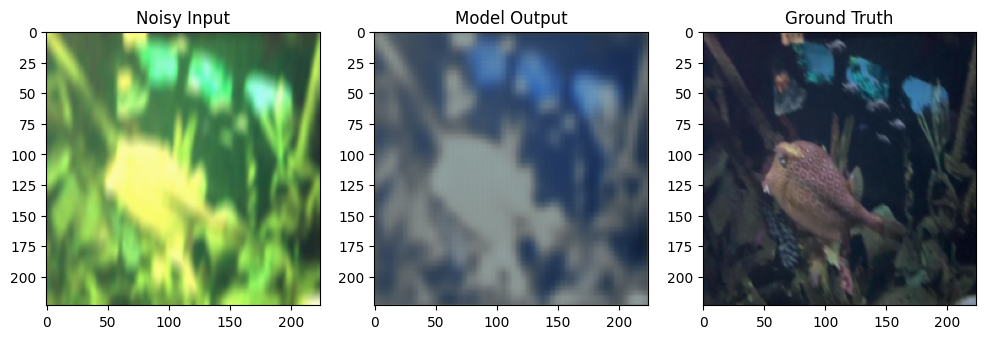

In [281]:
visualize_output(model=model_vis, data=train_data, device=device, idx=400, normalize=False)

In [24]:
model_simple

DenoisingCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [25]:
model_unet

DenoisingUNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (enc_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (enc_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv3a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.4, inplace=False)
  (dec_conv1): Sequential(
    